In [2]:
import pandas as pd
import numpy as np
import itertools as it
import functools as ft
import multiprocessing as mp
from time import time
from collections import OrderedDict
import sys
import tqdm

from sklearn.model_selection import KFold
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model.coordinate_descent import LinearModelCV
from sklearn.linear_model import ElasticNetCV
from sklearn.base import RegressorMixin
from sklearn.linear_model.base import LinearModel
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.base import BaseEstimator
from sklearn.kernel_ridge import KernelRidge

from scipy.stats import norm
from scipy.stats.mstats import gmean
from collections import Counter


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
agg_data = pd.read_csv('../data/agg_growth.csv', index_col=0)
agg_data.head()

,Drug,Concentration,Target,Growth,AAK1,ABL1,ABL2,ACVR1,ACVR1B,ACVR2B,...,uacc812,uacc893,umc11,umuc3,vmrclcd,wm115,wm2664,yapc,zr751,zr75b
53257,silmitasertib,3.00,-0.426184,-0.330026,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0
42989,osi027,0.03,2.489425,0.987205,0.0,0.000000,0.000000,0.0,0.076540,0.0,...,0,0,0,0,0,0,0,0,0,0
36715,mgcd265,0.30,3.085930,0.997971,0.0,-0.367669,-0.212716,0.0,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0
35826,masitinib,1.00,0.895365,0.629408,0.0,-0.478263,-0.317027,0.0,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0
43312,osi027,30.00,-0.056795,-0.045292,0.0,0.000000,0.000000,0.0,-9.642757,0.0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# filter out the less common drugs
drugs = agg_data.Drug
c = Counter(drugs)
filtered_drug_list = [x for x,y in c.most_common() if y > 50]
drug_filter = drugs.isin(filtered_drug_list)
drugs = drugs[drug_filter]
agg_data = agg_data[drug_filter]

conc = agg_data.Concentration

# targ = agg_data.Target # deprecated
y = agg_data.Growth
new_y = np.arctanh(y) # throws a warning as inf occurs
new_y[y == 1] = np.arctanh(1 - 1e-12) # replace inf with large number

X = agg_data[agg_data.columns[4:]]

print(X.shape)

/Users/isrobson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in arctanh
  del sys.path[0]
/Users/isrobson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in arctanh
  del sys.path[0]


(61824, 662)


In [5]:
model = KernelRidge()

In [7]:
model.fit(X.iloc[:10000, :], y[:10000])

KernelRidge(alpha=1, coef0=1, degree=3, gamma=None, kernel='linear',
      kernel_params=None)

In [8]:
model.score(X, y)

0.650345581815714

In [13]:
logo = LeaveOneGroupOut()

param_grid = {
    'alpha': [1, 1e-1, 1e-2, 1e-3],
    'kernel': ['rbf', 'poly', 'sigmoid', 'chi2'], 
    'gamma': np.logspace(-2, 2, 5)
}

search = GridSearchCV(KernelRidge(),
                     cv=logo.split(X.values, y.values, groups=drugs),
                     param_grid=param_grid,
                     n_jobs=11,
                     iid=False,
                     refit=False,
                     return_train_score=True,
                     verbose=True)

In [ ]:
search.fit(X.values, y.values)

Fitting 68 folds for each of 80 candidates, totalling 5440 fits


[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


In [ ]:
search_res = pd.DataFrame(search.cv_results_).T
search_res.to_csv('../results/KernelRidgeCV.csv')

### Test Set Analysis

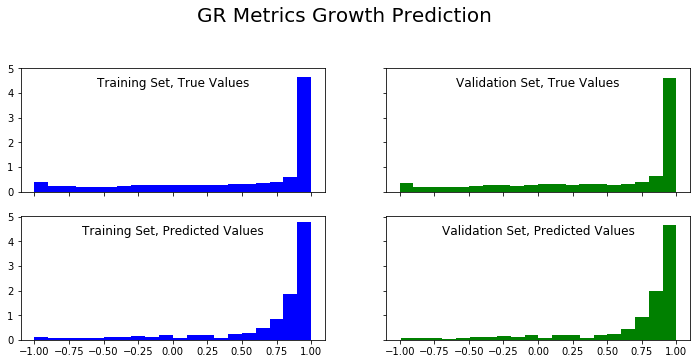

In [404]:
fig, axes = plt.subplots(figsize=(12,5), ncols=2, nrows=2, sharey=True, sharex=True)

plt.suptitle('GR Metrics Growth Prediction', y=1.05, fontsize=20)
#plt.title('+1 = No Effect, 0 = Cytostatic response, -1 = Cell Death', y=1.0, fontsize=10)

axes[0][0].hist(y['train'], bins=20, density=True, color='b')
axes[0][0].set_title('Training Set, True Values', y=.8)

axes[0][1].hist(y['dev'], bins=20, density=True, color='g')
axes[0][1].set_title('Validation Set, True Values', y=.8)

axes[1][0].hist((norm.cdf(p_train)-.5)*2, bins=20, density=True, color='b')
axes[1][0].set_title('Training Set, Predicted Values', y=.8)

axes[1][1].hist((norm.cdf(p_dev)-.5)*2, bins=20, density=True, color='g')
axes[1][1].set_title('Validation Set, Predicted Values', y=.8)

plt.show()